# Stochastic Gaussian Processes

# Background

The likelihood of a Multivariate Convolutional Gaussian Process (MGCP) is given as

\begin{equation}
\mathcal{L}(\boldsymbol{\theta}; \mathcal{D}) = 2\pi^{-P/2} |\boldsymbol{C}_{f,f} + \boldsymbol{\Sigma}|^{-1/2} \cdot \exp(-y(\boldsymbol{C}_{f,f} + \boldsymbol{\Sigma})^{-1}y^t / 2
\end{equation}

with corresponding log-likelihood

\begin{equation}
\ell(\theta; \mathcal{D}) = \ln \mathcal{L}(\theta, \mathcal{D}) \propto -y^t (C_{f,f} + \Sigma)^{-1} y - \ln |C_{f,f} + \Sigma|.
\end{equation}

Learning from this likelihood requires the inversion of $\boldsymbol{C}_{f,f} + \boldsymbol{\Sigma}$ and calculating its determinant at each step/iteration. There there are computational advances that speed up this process. Despite this, for a moderate number of outputs ($N$) we suffer from a large number of parameters and an non-convex objective function.

Stochastic Gradient Descent (SGD) is a common method to combat these conditions. But SGD on Gaussian processes has been understudied because the data is correlated.

# Setup

This document examines SGD with Gaussian processes. Specifically, we are seeing how well SGD works in optimizing the likelihood function. We have a few specific questions.

- How resilient is SGD to optimization hyperparameters, like starting point and batch size?
- Does SGD work well when we add more parameters?

We use "SGD for Correlated Data" by Moyan Li as a starting point and apply the [GPyTorch](https://gpytorch.ai) package.

In [1]:
import torch
import gpytorch
import math
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from collections import defaultdict

import sgp

import pdb

## Training and Testing

In [2]:
def trainSGD(model, likelihood, train_x, train_y, test_x, test_y,
             verbose = False, batch_size = 10, training_iter = 100, lr = 0.2):

    # SGD
    optimizer = torch.optim.SGD([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr = lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Collection of losses and MSEs
    losses, mses, parameters = list(), list(), defaultdict(list)
    
    # Displaying parameters
    print(f'{model.count_parameters()} Parameters to be Optimized. Initial values:')
    model.get_parameters(show = True)
    print('')
    
    # Training
    for i in range(training_iter):
        # Setting Training mode
        model.train()
        likelihood.train()
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        minibatch = np.random.choice(train_x.shape[0], batch_size, replace = False)
        output = model(train_x[minibatch])
        # Calc loss and backprop gradients
        loss = -mll(output, train_y[minibatch])
        loss.backward()
        if verbose and (not ((i+1) % 20) or i == 0):
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
            model.get_parameters(show = True)
        optimizer.step()
        # Recording actual parameters, loss, and MSE (in Evaluation Mode)
        model.eval()
        likelihood.eval()
        losses.append(loss.item())
        mses.append(mean_squared_error(test_y, model(test_x).mean.detach()))
        for k, v in model.get_parameters(raw = False).items():
            parameters[k].append(v)
        
    return(losses, mses, parameters)
        
def test(model, test_x):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(test_x))
        return(test_pred)

# Simulation 1. One dimension, one parameter (from Li)

In [3]:
def f1(x):
    return torch.div(torch.mul(x, x), 1 - x)

# Generating Data
train_x, test_x = torch.linspace(0, 0.8, 10), torch.linspace(0, 0.8, 15)
train_y, test_y = f1(train_x), f1(test_x)

# True parameter values
truths = {'covar_module.base_kernel.lengthscale':0.3}

Trial 1

4 Parameters to be Optimized. Initial values:
   Parameter name: likelihood.noise_covar.raw_noise           value = -2.2532198429107666
   Parameter name: mean_module.constant                       value = 0.0
   Parameter name: covar_module.raw_outputscale               value = 2.9489307403564453
   Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0



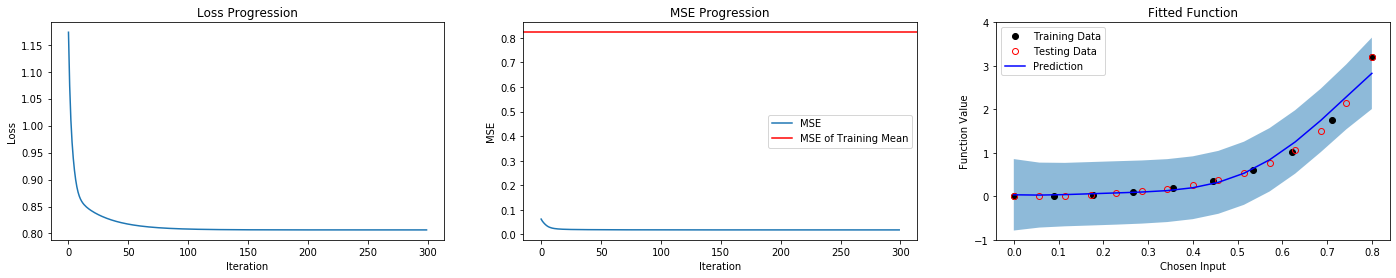

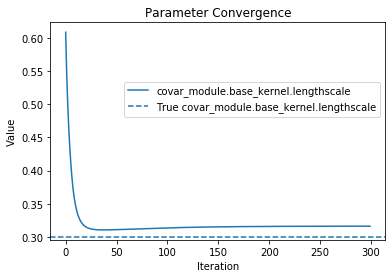

In [4]:
for i in range(1):
    print("Trial " + str(i + 1) + "\n")
    
    # Model Setup
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = sgp.models.VanillaSGP(train_x, train_y, likelihood)
    # Setting non-trained parameters to match 'one dimension, three parameters' example
    model.likelihood.noise_covar.noise = 0.1
    model.likelihood.noise_covar.raw_noise.requires_grad = False
    model.covar_module.outputscale = 3
    model.covar_module.raw_outputscale.requires_grad = False
    
    # Training
    losses, mses, parameters = trainSGD(model, likelihood, train_x, train_y, test_x, test_y, 
                                        lr = 0.3, batch_size = 10, training_iter = 300, verbose = False)
    
    # Removing manually set parameters (and mean, since it is not of interest)
    for param_name in ['likelihood.noise_covar.noise', 'mean_module.constant', 'covar_module.outputscale']:
        parameters.pop(param_name)
    
    # Predicting
    test_pred = test(model, test_x)
    
    # Plotting
    f, ax = plt.subplots(1, 3, figsize = (24, 4))
    ax[0] = sgp.plotting.plot_loss(ax[0], losses)
    ax[1] = sgp.plotting.plot_mses(ax[1], mses, sgp.helpers.baseline_mse(train_y, test_y))
    ax[2] = sgp.plotting.plot_function(ax[2], train_x, train_y, test_x, test_y, test_pred)
    plt.show()
    f, ax = plt.subplots(figsize = (6, 4))
    ax = sgp.plotting.plot_parameters(ax, parameters, truths)
    plt.show()

# Simulation 2. One dimension, three parameters (from Li)

In [35]:
# Forming covariance matrices
data_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
data_kernel.outputscale = 4
data_kernel.base_kernel.lengthscale = 2
Sigma_train = (data_kernel.forward(train_x, train_x) + torch.diag(torch.Tensor([0.1**2 for _ in train_x]))).detach().numpy()
Sigma_test = (data_kernel.forward(test_x, test_x) + torch.diag(torch.Tensor([0.1**2 for _ in test_x]))).detach().numpy()

# Generating data
n_train, n_test = 100, 999
train_x = torch.linspace(0, 100, n_train)
test_x = torch.linspace(0, 100, n_test)
train_y = torch.Tensor(np.random.multivariate_normal(np.zeros(n_train), Sigma_train, size = 1).ravel())
test_y = torch.Tensor(np.random.multivariate_normal(np.zeros(n_test), Sigma_test, size = 1).ravel())

# Summarizing 'true' parameter values
truths = {'likelihood.noise_covar.noise':0.1, 'covar_module.outputscale':4, 'covar_module.base_kernel.lengthscale':2}

# Defining Li's learning rate adjustment
def update_lr(optimizer, epoch):
    lr = 0.08 / np.ceil(epoch / 12)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Trial 1

4 Parameters to be Optimized. Initial values:
   Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
   Parameter name: mean_module.constant                       value = 0.0
   Parameter name: covar_module.raw_outputscale               value = 0.0
   Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0



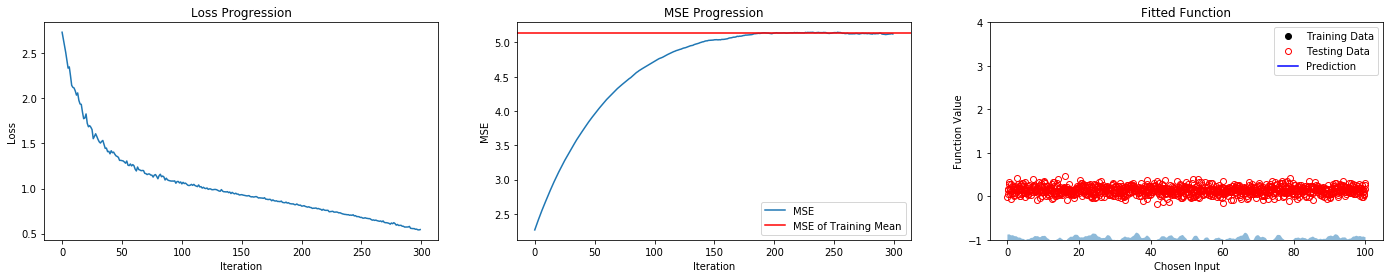

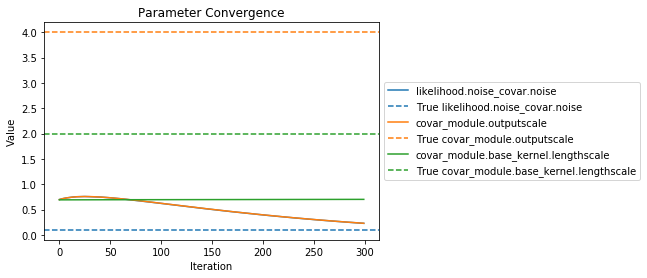

In [36]:
for i in range(1):
    print("Trial " + str(i + 1) + "\n")
    
    # Model Setup
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = sgp.models.VanillaSGP(train_x, train_y, likelihood)
    
    # Training
    losses, mses, parameters = trainSGD(model, likelihood, train_x, train_y, test_x, test_y, 
                                        lr = 0.3, batch_size = 4, training_iter = 300, verbose = False)
    
    # Removing mean, since it is not of interest
    for param_name in ['mean_module.constant']:
        parameters.pop(param_name)
    
    # Predicting
    test_pred = test(model, test_x)
    
    # Plotting
    f, ax = plt.subplots(1, 3, figsize = (24, 4))
    ax[0] = sgp.plotting.plot_loss(ax[0], losses)
    ax[1] = sgp.plotting.plot_mses(ax[1], mses, sgp.helpers.baseline_mse(train_y, test_y))
    ax[2] = sgp.plotting.plot_function(ax[2], train_x, train_y, test_x, test_y, test_pred)
    plt.show()
    f, ax = plt.subplots(figsize = (6, 4))
    ax = sgp.plotting.plot_parameters(ax, parameters, truths)
    plt.show()

# Simulation 3. More dimensions

We use a separate lengthscale for each dimension as done by Li, but modify the kernel a small amount to make computation faster. Specifically, we change the kernel from $K(\boldsymbol{x}, \boldsymbol{x'}) = \sigma \exp \Big( -\frac{1}{2} \sum_{i=1}^{d} \frac{|x_i - x_i'|}{l_i} \Big)$ to $K(\boldsymbol{x}, \boldsymbol{x'}) = \sigma \exp \Big( -\frac{1}{2} \sqrt{\sum_{i=1}^{d} \frac{(x_i - x_i')^2}{l_i^2}} \Big)$.

In [6]:
# Kernel used by Li in simulation study with different lengthscales for each dimension.
# i and j are both vectors of dimension between 1 and 5.
def flex_kernel(i, j):
    # Computing kernel coefficients. This way, we can experiment with dimensions lower than 5.
    full_coefs = np.array((1, 1/4, 1/9, 1/16, 1/4))
    coefs = full_coefs[:len(i)]
    # Computing kernel
    summation = np.dot(np.absolute(i - j), coefs)
    return 4**2 * np.exp(-1/2 * summation)

# Apply a kernel function to a dataset. Output is (n x n) numpy array.
def apply_kernel(data, kernel):
    n = len(data)
    out = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            out[i, j] = kernel(data[i], data[j])
    return out

# Generating data
n, d, sigma = 100, 3, 1e-4
train_x = torch.Tensor(np.random.multivariate_normal(np.zeros(d), np.identity(d), size = n))
test_x = torch.Tensor(np.random.multivariate_normal(np.zeros(d), np.identity(d), size = n))
train_y = torch.Tensor(np.random.multivariate_normal(
    np.zeros(n), apply_kernel(train_x, flex_kernel) + sigma * np.identity(n), size = 1).ravel())
test_y = torch.Tensor(np.random.multivariate_normal(
    np.zeros(n), apply_kernel(test_x, flex_kernel) + sigma * np.identity(n), size = 1).ravel())

In [7]:
for i in range(1):
    print("Trial " + str(i + 1) + "\n")
    
    # Fitting
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = sgp.models.FlexSGP(train_x, train_y, likelihood)
    losses, mses = trainSGD(model, likelihood, train_x, train_y, test_x, test_y, 
                            lr = 0.2, batch_size = 5, training_iter = 200, verbose = True)
    
    # Plotting
    f, ax = plt.subplots(1, 2, figsize = (24, 4))
    ax[0] = sgp.plotting.plot_loss(ax[0], losses)
    ax[1] = sgp.plotting.plot_mses(ax[1], mses, sgp.helpers.baseline_mse(train_y, test_y))
    plt.show()

Trial 1

6 Parameters to be Optimized:
> /Users/Sam/Research/sgp/models.py(35)print_parameters()
-> for param_name, param in self.named_parameters():


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(36)print_parameters()
-> try:


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(37)print_parameters()
-> print(f'   Parameter name: {param_name:42} value = {param.item()}')


(Pdb)  type(self.named_parameters())


<class 'generator'>


(Pdb)  type(param)


<class 'torch.nn.parameter.Parameter'>


(Pdb)  type(param.item())


<class 'float'>


(Pdb)  type(param.data)


<class 'torch.Tensor'>


(Pdb)  param.data


tensor([0.])


(Pdb)  param.item()


0.0


(Pdb)  n


   Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
> /Users/Sam/Research/sgp/models.py(35)print_parameters()
-> for param_name, param in self.named_parameters():


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(36)print_parameters()
-> try:


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(37)print_parameters()
-> print(f'   Parameter name: {param_name:42} value = {param.item()}')


(Pdb)  param.item()


0.0


(Pdb)  n


   Parameter name: mean_module.constant                       value = 0.0
> /Users/Sam/Research/sgp/models.py(35)print_parameters()
-> for param_name, param in self.named_parameters():


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(36)print_parameters()
-> try:


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(37)print_parameters()
-> print(f'   Parameter name: {param_name:42} value = {param.item()}')


(Pdb)  param.item()


0.0


(Pdb)  n


   Parameter name: covar_module.raw_outputscale               value = 0.0
> /Users/Sam/Research/sgp/models.py(35)print_parameters()
-> for param_name, param in self.named_parameters():


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(36)print_parameters()
-> try:


(Pdb)  n


> /Users/Sam/Research/sgp/models.py(37)print_parameters()
-> print(f'   Parameter name: {param_name:42} value = {param.item()}')


(Pdb)  type(param.item())


*** ValueError: only one element tensors can be converted to Python scalars


(Pdb)  param.data()


*** TypeError: 'Tensor' object is not callable


(Pdb)  param.data


tensor([0., 0., 0.])


(Pdb)  q


BdbQuit: 

## Notes

- Start with RBF kernel and small batch sizes (4, 8). The largest batch size Li used was 5.
- We can add regularization in GPs if necessary.
- We can forget about Negative Transfer for now.
- Hao is working on a bound for prediction error based on eigenvalues of covariance matrix.
- Tutorial on parallelization in GPyTorch is available [here](https://gpytorch.readthedocs.io/en/latest/examples/01_Simple_GP_Regression/Simple_MultiGPU_GP_Regression.html)

**Future directions**
- multivariate data